In [429]:
#data manipulation
from pathlib import Path
import numpy as np
from numpy import percentile
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import glob
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from math import sqrt
import scipy.stats

#double iteration in pandas
from itertools import product

#compute distance between two points on earth
from haversine import haversine, haversine_vector, Unit

#mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import gdal

#colorbars
import cmocean
import cmaps

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
import matplotlib.patches as patches
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
import seaborn as seabornInstance 
from windrose import WindroseAxes
import seaborn as sns; sns.set(color_codes=True)
from matplotlib import style
style.use('fivethirtyeight')

%matplotlib inline

# SARAL-AltiKa 

In [2]:
# function to remove outliers from every single along track

def remove_outliers(fname):
    
    #read the data files
    df2 = xr.open_dataset(fname)
    
    #select all the required variables to detect only the valid data
    df2 = df2[['swh','swh_rms','surface_type','wind_speed_alt','ice_flag','sig0','off_nadir_angle_wf','sig0_rms','range_rms','swh_numval', \
           'swh_rms']]
    
    # convert to pandas dataframe
    df2 = df2.to_dataframe()
    df2.reset_index(inplace=True)
    
        # apply the filtering criteria
    df2 = df2[(df2['surface_type'] == 0.) & (df2['ice_flag'] == 0.) & (df2['swh'] < 30.) & (df2['sig0'] < 30.) & (df2['sig0'] > 3.) \
            & (df2['off_nadir_angle_wf'] < 0.0625) & (df2['off_nadir_angle_wf'] > -0.2) & (df2['wind_speed_alt'] < 30) & \
             (df2['sig0_rms'] < 1) & (df2['range_rms'] < 0.2) & (df2['swh_numval'] > 20) & (df2['swh_rms'] < df2['swh'])]
    
    outliers_removed = df2
    
    """
    # remove outliers from significant wave height
    q1 = df2['swh'].quantile(0.25)
    q3 = df2['swh'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    outliers_removed = df2.loc[(df2['swh'] > fence_low) & (df2['swh'] < fence_high)]
    
    
    
    #use the standard deviation method
    
    # calculate summary statistics
    data_mean, data_std = np.mean(df2['swh']), np.std(df2['swh'])
    #identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # remove outliers
    outliers_removed = df2.loc[(df2['swh'] > lower) & (df2['swh'] < upper)]
    
    
    
    #remove outliers from wind speed
    q1 = df2['wind_speed_alt'].quantile(0.25)
    q3 = df2['wind_speed_alt'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers_removed = df2.loc[(df2['wind_speed_alt'] > fence_low) & (df2['wind_speed_alt'] < fence_high)]
    
    """

    return outliers_removed

In [3]:
# import all data files
p = Path('C:/Users/panmits86/Desktop/SA_val')
#p = Path('C:/Users/panmits86/Desktop/SA_GDR')
#p = Path('C:/Users/panmits86/masters_thesis/data/satellite/SARAL-AltiKa/IGDR/2014_Q4')
# iterate the process to every data file
results = []
for fname in p.glob('*.nc'):
    swh_sa = remove_outliers(fname)
    results.append(swh_sa)
    swh_s = pd.concat(results)

In [4]:
swh_sa = swh_s[['time','lon','lat','swh','wind_speed_alt']]
swh_sa = swh_sa.reset_index()
swh_sa.drop(['index'], axis=1, inplace=True)
swh_sa 

,time,lon,lat,swh,wind_speed_alt
0,2014-08-21 23:28:09.197778944,286.287362,40.555752,0.652,4.24
1,2014-08-21 23:28:11.270705920,286.247050,40.434171,0.829,5.36
2,2014-08-21 23:28:13.343635072,286.206852,40.312579,0.775,5.10
3,2014-08-21 23:28:14.380099072,286.186796,40.251778,0.814,5.07
4,2014-08-21 23:28:15.416562112,286.166767,40.190975,0.816,4.96
...,...,...,...,...,...
8484,2019-12-22 10:22:46.047041920,286.145365,40.025461,0.576,4.69
8485,2019-12-22 10:22:47.084560896,286.125404,40.086325,0.296,4.74
8486,2019-12-22 10:22:48.122082176,286.105414,40.147186,0.407,4.58
8487,2019-12-22 10:22:49.159601152,286.085398,40.208044,0.489,4.26


In [52]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(15, 20),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator([-74, -73, -72, -71, -70])
    gl.ylocator = mticker.FixedLocator([40, 41, 42])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

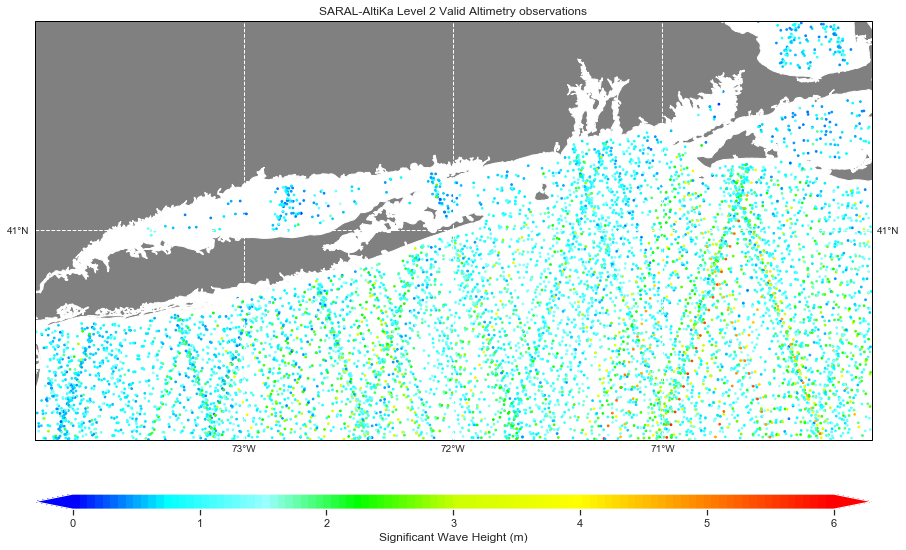

In [53]:
# Map of Wave Height observations

fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

#cmap=cmaps.GMT_seis_r
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,1,2,3,4,5,6])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=12)
norm = mpl.colors.Normalize(vmin=0, vmax=6)
cs2 = plt.scatter(swh_sa['lon'], swh_sa['lat'], c=swh_sa['swh'], s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=12)
ax.set_title('SARAL-AltiKa Level 2 Valid Altimetry observations',size=12)
plt.savefig('SNE_obs_SA_wh_valid.png', dpi=300, bbox_inches='tight')

In [5]:
buoys = pd.read_excel('buoys.xlsx', header=0, index_col=None, usecols="D:E")

In [6]:
# coordinates of buoy 44017
b44017 = (buoys['Latitude'][3],buoys['Longitude'][3]+360)
b44017

(40.693, 287.951)

In [7]:
# make a parser to include minutes, hours, days, months, years in one column and convert to datetime
def parse(yr, mo, doy, hr, min):
    yr, mo, doy, hr, min = [int(x) for x in [yr, mo, doy, hr, min]]
    dt = datetime(yr - 0, mo, doy, hr, min)
    return dt

In [821]:
#read all files since 2016 for the 44097 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44017_1'
all_files = glob.glob(path + "/*.txt")

b44017_wind_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44017_wind_wave = b44017_wind_wave[(b44017_wind_wave.WVHT !=99) & (b44017_wind_wave.WVHT > 0.0) &
                                   (b44017_wind_wave.WSPD !=99) & (b44017_wind_wave.WSPD > 0.0)]
b44017_wind_wave.reset_index(inplace=True)
b44017_wind_wave.drop('index', 1, inplace=True)
#b44017_wind_wave['u10'] = b44017_wind_wave['WSPD']*(10/4.1)**0.11
b44017_wind_wave['u10'] = b44017_wind_wave['WSPD']*np.sqrt((0.4**2)/0.0013)*(1/(np.log(4.1/0.000097)))
b44017_wind_wave

,Date,WSPD,WVHT,u10
0,2013-12-31 23:50:00,13.6,1.81,14.164615
1,2014-01-01 00:50:00,13.0,1.94,13.539705
2,2014-01-01 01:50:00,11.7,1.96,12.185735
3,2014-01-01 02:50:00,11.0,1.97,11.456674
4,2014-01-01 03:50:00,11.5,1.86,11.977432
...,...,...,...,...
31346,2019-08-23 06:40:00,3.9,1.37,4.061912
31347,2019-08-23 07:40:00,4.0,1.36,4.166063
31348,2019-08-23 08:40:00,4.6,1.38,4.790973
31349,2019-08-23 09:40:00,3.5,1.31,3.645305


In [735]:
b44017_time = b44017_wind_wave['Date']
b44017_time

0       2013-12-31 23:50:00
1       2014-01-01 00:50:00
2       2014-01-01 01:50:00
3       2014-01-01 02:50:00
4       2014-01-01 03:50:00
                ...        
31346   2019-08-23 06:40:00
31347   2019-08-23 07:40:00
31348   2019-08-23 08:40:00
31349   2019-08-23 09:40:00
31350   2019-08-23 10:40:00
Name: Date, Length: 31351, dtype: datetime64[ns]

In [736]:
a1 = [(swh_sa['lat'][n], swh_sa['lon'][n]) for n in range(swh_sa.shape[0])]

In [737]:
# compute the distance between each SARAL-AltiKa datapoint and the position of buoy 44017
hav5 = haversine_vector([b44017]*swh_sa.shape[0],a1, Unit.KILOMETERS)
coloc = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])
coloc

,Buoy-Sat. Distance (km)
0,141.229915
1,146.784680
2,153.411456
3,157.085329
4,160.978039
...,...
8484,170.043246
8485,168.685121
8486,167.606105
8487,166.811354


In [738]:
swh_sa['Buoy-Sat. Distance (km)'] = coloc
swh_sa

,time,lon,lat,swh,wind_speed_alt,Buoy-Sat. Distance (km)
0,2014-08-21 23:28:09.197778944,286.287362,40.555752,0.652,4.24,141.229915
1,2014-08-21 23:28:11.270705920,286.247050,40.434171,0.829,5.36,146.784680
2,2014-08-21 23:28:13.343635072,286.206852,40.312579,0.775,5.10,153.411456
3,2014-08-21 23:28:14.380099072,286.186796,40.251778,0.814,5.07,157.085329
4,2014-08-21 23:28:15.416562112,286.166767,40.190975,0.816,4.96,160.978039
...,...,...,...,...,...,...
8484,2019-12-22 10:22:46.047041920,286.145365,40.025461,0.576,4.69,170.043246
8485,2019-12-22 10:22:47.084560896,286.125404,40.086325,0.296,4.74,168.685121
8486,2019-12-22 10:22:48.122082176,286.105414,40.147186,0.407,4.58,167.606105
8487,2019-12-22 10:22:49.159601152,286.085398,40.208044,0.489,4.26,166.811354


In [769]:
# keep satellite observations in a radius of 0.25 degrees relative to the buoy
#dist = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])
radius = swh_sa['Buoy-Sat. Distance (km)'] < 27.75
colocated = swh_sa[radius]
colocated.reset_index(inplace=True)
colocated.drop('index', 1, inplace=True)
colocated

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,time,lon,lat,swh,wind_speed_alt,Buoy-Sat. Distance (km)
0,2014-09-14 10:21:57.582557888,288.121075,40.599083,1.530,9.360000,17.746944
1,2014-09-22 23:22:17.267220992,287.823030,40.859468,1.941,8.250000,21.418436
2,2014-09-22 23:22:18.304742080,287.802701,40.798645,1.987,9.200000,17.148607
3,2014-10-19 10:21:56.373651968,288.102815,40.639992,1.857,9.010000,14.096051
4,2014-10-19 10:21:58.447635904,288.062288,40.761600,1.914,9.679999,12.088409
...,...,...,...,...,...,...
508,2019-08-16 10:15:37.358751744,287.874349,40.749484,1.091,4.780000,9.009727
509,2019-08-16 10:15:38.396273152,287.854043,40.810313,1.114,4.460000,15.390438
510,2019-08-16 10:15:39.433792128,287.833708,40.871139,1.156,3.720000,22.133494
511,2019-09-01 10:16:33.065669120,287.662434,40.605174,0.676,5.240000,26.230630


In [770]:
sat_time = colocated['time'].reset_index()
sat_time.drop('index', 1, inplace=True)
sat_time['time']

0     2014-09-14 10:21:57.582557888
1     2014-09-22 23:22:17.267220992
2     2014-09-22 23:22:18.304742080
3     2014-10-19 10:21:56.373651968
4     2014-10-19 10:21:58.447635904
                   ...             
508   2019-08-16 10:15:37.358751744
509   2019-08-16 10:15:38.396273152
510   2019-08-16 10:15:39.433792128
511   2019-09-01 10:16:33.065669120
512   2019-09-01 10:16:34.103189888
Name: time, Length: 513, dtype: datetime64[ns]

In [771]:
#time difference in minutes
diff = [(b44017_time[d], b44017_wind_wave['WVHT'][d], b44017_wind_wave['u10'][d], sat_time['time'][s], colocated['swh'][s], \
         colocated['wind_speed_alt'][s], colocated['Buoy-Sat. Distance (km)'][s], (sat_time['time'][s] - b44017_time[d]).total_seconds() / 60) \
        for d, s in product(range(b44017_time.shape[0]), range(sat_time.shape[0]))]

In [772]:
t = pd.DataFrame(list(diff))
t.columns = ['Buoy 44017 Time', 'Buoy 44017 Wave Height', 'Buoy 44017 U10', 'SARAL-AltiKa Time', 'SARAL-AltiKa Wave Height', \
             'SARAL-AltiKa Wind Speed', 'Buoy-Sat. Distance (km)', 'Time Difference (min.)']

In [893]:
final1 = pd.read_csv('C:/Users/panmits86/Desktop/Python/b44017_SARAL_0.25deg_radius_dcd.txt',  sep='\t')
final1

,Buoy 44017 Time,Buoy 44017 Wave Height,Buoy 44017 U10,SARAL-AltiKa Time,SARAL-AltiKa Wave Height,SARAL-AltiKa Wind Speed,Buoy-Sat. Distance (km),Time Difference (min.)
0,2015-05-17 10:50:00.000000000,1.13,1.874728,2015-05-17 10:21:24.779890048,1.243,4.01,20.375477,-28.587002
1,2015-05-17 10:50:00.000000000,1.13,1.874728,2015-05-17 10:21:25.816355968,1.182,3.67,16.774255,-28.569727
2,2015-05-17 10:50:00.000000000,1.13,1.874728,2015-05-17 10:21:28.925748096,1.354,3.52,21.524766,-28.517904
3,2015-05-17 10:50:00.000000000,1.13,1.874728,2015-05-17 10:21:29.962208960,1.409,2.98,26.802650,-28.500630
4,2015-05-25 23:50:00.000000000,0.78,9.477794,2015-05-25 23:21:34.382832064,0.975,7.29,15.264245,-28.426953
...,...,...,...,...,...,...,...,...
326,2019-08-16 10:40:00.000000000,1.17,4.999276,2019-08-16 10:15:35.283711872,1.156,5.11,7.862519,-24.411938
327,2019-08-16 10:40:00.000000000,1.17,4.999276,2019-08-16 10:15:36.321230848,1.166,5.14,4.777554,-24.394646
328,2019-08-16 10:40:00.000000000,1.17,4.999276,2019-08-16 10:15:37.358751744,1.091,4.78,9.009727,-24.377354
329,2019-08-16 10:40:00.000000000,1.17,4.999276,2019-08-16 10:15:38.396273152,1.114,4.46,15.390438,-24.360062


In [862]:
final = abs(t['Time Difference (min.)']) < 30.
final = t[final]
final

,Buoy 44017 Time,Buoy 44017 Wave Height,Buoy 44017 U10,SARAL-AltiKa Time,SARAL-AltiKa Wave Height,SARAL-AltiKa Wind Speed,Buoy-Sat. Distance (km),Time Difference (min.)
1870447,2015-05-17 10:50:00,1.13,1.874728,2015-05-17 10:21:24.779890048,1.243,4.01,20.375477,-28.587002
1870448,2015-05-17 10:50:00,1.13,1.874728,2015-05-17 10:21:25.816355968,1.182,3.67,16.774255,-28.569727
1870449,2015-05-17 10:50:00,1.13,1.874728,2015-05-17 10:21:28.925748096,1.354,3.52,21.524766,-28.517904
1870450,2015-05-17 10:50:00,1.13,1.874728,2015-05-17 10:21:29.962208960,1.409,2.98,26.802650,-28.500630
1975103,2015-05-25 23:50:00,0.78,9.477794,2015-05-25 23:21:34.382832064,0.975,7.29,15.264245,-28.426953
...,...,...,...,...,...,...,...,...
15996872,2019-08-16 10:40:00,1.17,4.999276,2019-08-16 10:15:35.283711872,1.156,5.11,7.862519,-24.411938
15996873,2019-08-16 10:40:00,1.17,4.999276,2019-08-16 10:15:36.321230848,1.166,5.14,4.777554,-24.394646
15996874,2019-08-16 10:40:00,1.17,4.999276,2019-08-16 10:15:37.358751744,1.091,4.78,9.009727,-24.377354
15996875,2019-08-16 10:40:00,1.17,4.999276,2019-08-16 10:15:38.396273152,1.114,4.46,15.390438,-24.360062


In [854]:
final.to_csv('b44017_SARAL_0.25deg_radius_dcd.txt', sep='\t', index=False)

In [894]:
final1 = final1.set_index('Buoy 44017 Time')
final1

,Buoy 44017 Wave Height,Buoy 44017 U10,SARAL-AltiKa Time,SARAL-AltiKa Wave Height,SARAL-AltiKa Wind Speed,Buoy-Sat. Distance (km),Time Difference (min.)
Buoy 44017 Time,,,,,,,
2015-05-17 10:50:00.000000000,1.13,1.874728,2015-05-17 10:21:24.779890048,1.243,4.01,20.375477,-28.587002
2015-05-17 10:50:00.000000000,1.13,1.874728,2015-05-17 10:21:25.816355968,1.182,3.67,16.774255,-28.569727
2015-05-17 10:50:00.000000000,1.13,1.874728,2015-05-17 10:21:28.925748096,1.354,3.52,21.524766,-28.517904
2015-05-17 10:50:00.000000000,1.13,1.874728,2015-05-17 10:21:29.962208960,1.409,2.98,26.802650,-28.500630
2015-05-25 23:50:00.000000000,0.78,9.477794,2015-05-25 23:21:34.382832064,0.975,7.29,15.264245,-28.426953
...,...,...,...,...,...,...,...
2019-08-16 10:40:00.000000000,1.17,4.999276,2019-08-16 10:15:35.283711872,1.156,5.11,7.862519,-24.411938
2019-08-16 10:40:00.000000000,1.17,4.999276,2019-08-16 10:15:36.321230848,1.166,5.14,4.777554,-24.394646
2019-08-16 10:40:00.000000000,1.17,4.999276,2019-08-16 10:15:37.358751744,1.091,4.78,9.009727,-24.377354


### 25 km Radius

In [895]:
final1.index = pd.to_datetime(final1.index)

In [896]:
df = final1.iloc[:,[0,1,3,4]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
df = df.resample('D').mean()
df = df.dropna()
len(df)

61

In [897]:
x = df['Buoy 44017 U10']
y = df['Buoy 44017 Wave Height']

xx = df['SARAL-AltiKa Wind Speed']
yy = df['SARAL-AltiKa Wave Height']

In [898]:
model = LinearRegression(fit_intercept=False)

model.fit(x[:, np.newaxis], xx)

x1fit = np.linspace(0, 17, 61)
y1fit = model.predict(x1fit[:, np.newaxis])

print("Model slope:", model.coef_[0])

Model slope: 0.916273707640799


In [899]:
# model line slope
model.coef_

array([0.91627371])

In [900]:
scores_mean = list()
scores_std = list()

scores = cross_validate(model, x[:, np.newaxis], xx, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

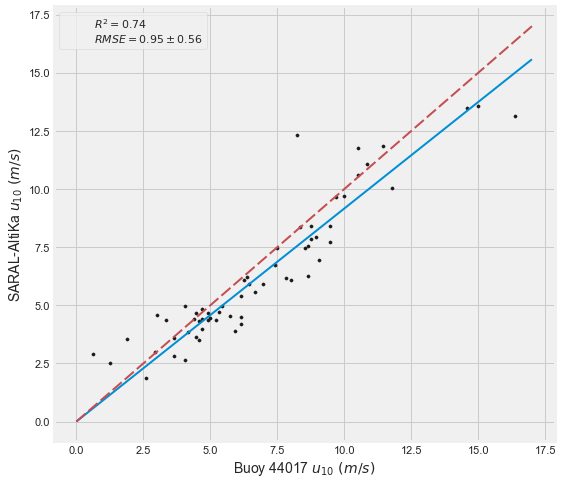

In [901]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(x, xx, s=10, color='k', label='data')
plt.plot(x1fit, y1fit, linewidth=2, label='fitted')
plt.plot([0, 17], [0, 17], dashes=[6, 2], linewidth=2, color='r', label='1-1 line')

plt.xlabel('Buoy 44017 $u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('SARAL-AltiKa $u_{10} \ (m/s)$', fontsize=14)

extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False, edgecolor='none', linewidth=0)
ax.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$').format(np.mean(scores['test_r2']),
                                                      -np.mean(scores['test_neg_root_mean_squared_error']),
                                                      np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')

In [902]:
model = LinearRegression(fit_intercept=False)

model.fit(y[:, np.newaxis], yy)

x2fit = np.linspace(0, 4, 1000)
y2fit = model.predict(x2fit[:, np.newaxis])

print("Model slope:", model.coef_)
#print("Model intercept:", model.intercept_)

Model slope: [1.01055822]


In [903]:
scores_mean = list()
scores_std = list()

scores = cross_validate(model, y[:, np.newaxis], yy, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

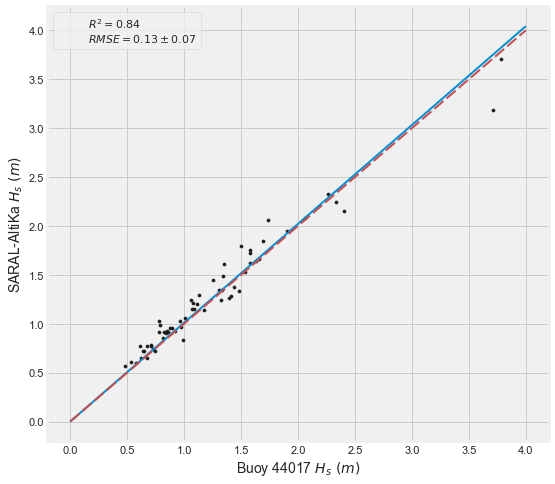

In [904]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(y, yy, s=10, color='k', label='data')
plt.plot(x2fit, y2fit, linewidth=2, label='fitted')
plt.plot([0, 4], [0, 4], dashes=[6, 2], linewidth=2, color='r', label='1-1 line')

plt.xlabel('Buoy 44017 $H_{s} \ (m)$', fontsize=14)
plt.ylabel('SARAL-AltiKa $H_{s} \ (m)$', fontsize=14)

extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
ax.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$').format(np.mean(scores['test_r2']),
                                                      -np.mean(scores['test_neg_root_mean_squared_error']),
                                                      np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')
#ax.legend(loc='best')

In [834]:
model1 = LinearRegression(fit_intercept=False)

#model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 18, 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model1)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

In [835]:
# model / line coefficients
poly_model.steps[1][1].coef_

array([ 0.99474621, -0.09040481,  0.01526585])

In [836]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model, x[:, np.newaxis], y, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

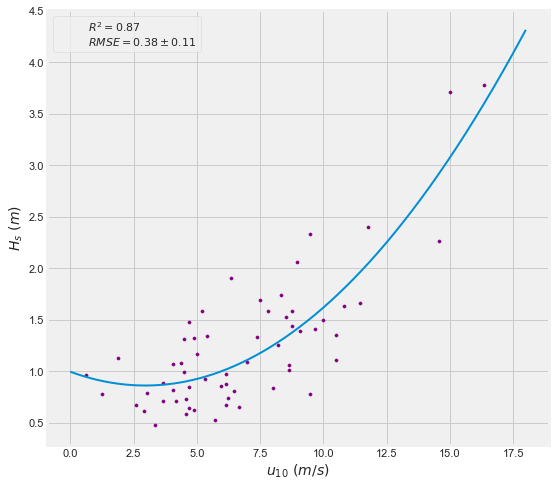

In [837]:
# plot time series of wave height and save figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=10,color='purple', label='Buoy 44017 data')

ax.plot(xfit, yfit, linewidth=2, label='Buoy 44017')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
#ax.legend(loc='best')
extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
ax.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_r2']),
                                                      -np.mean(scores['test_neg_root_mean_squared_error']),
                                                      np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')

In [842]:
model2 = LinearRegression(fit_intercept=False)

#model.fit(xx[:, np.newaxis], yy)
xxfit = np.linspace(0, 18, 1000)

poly_model1 = make_pipeline(PolynomialFeatures(2), model2)

poly_model1.fit(xx[:, np.newaxis], yy)
yyfit = poly_model1.predict(xxfit[:, np.newaxis])

In [843]:
poly_model1.steps[1][1].coef_

array([0.76160419, 0.01674942, 0.00870768])

In [844]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model1, xx[:, np.newaxis], yy, scoring=['r2', 'neg_root_mean_squared_error'], cv=15)

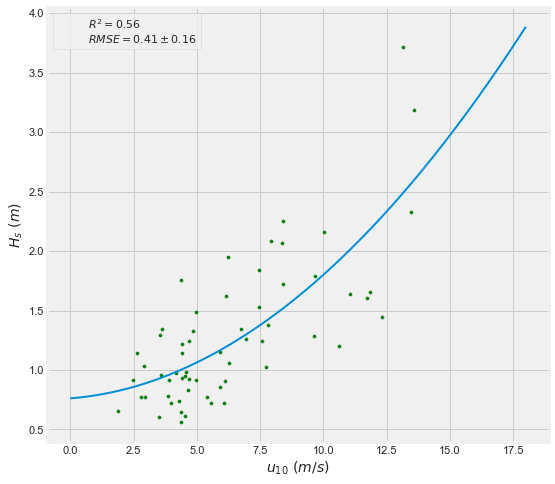

In [845]:
# plot time series of wave height and save figure
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(xx, yy, s=10, color='green', label='SARAL-AltiKa data')
ax.plot(xxfit, yyfit, linewidth=2, label="SARAL-AltiKa")

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
#ax.legend(loc='best')
extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
ax.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_r2']),
                                                      -np.mean(scores['test_neg_root_mean_squared_error']),
                                                      np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')

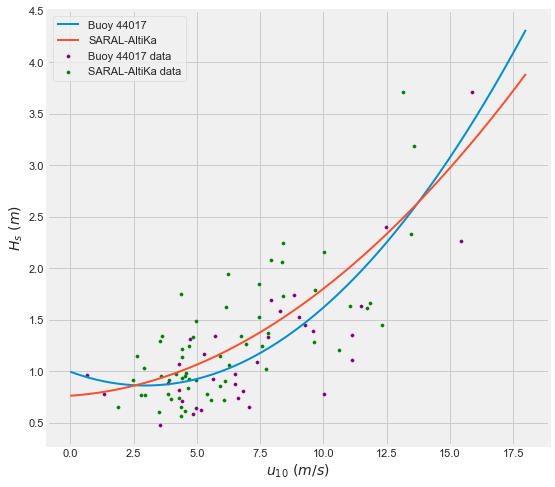

In [847]:
# plot time series of wave height and save figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df5['Buoy 44017 U10'],df5['Buoy 44017 Wave Height'],s=10,color='purple', label='Buoy 44017 data')
ax.scatter(xx, yy, s=10, color='green', label='SARAL-AltiKa data')
ax.plot(xfit, yfit, linewidth=2, label='Buoy 44017')
ax.plot(xxfit, yyfit, linewidth=2, label="SARAL-AltiKa")
plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
ax.legend(loc='best')

## 15 km Radius

In [866]:
final1.index = pd.to_datetime(final1.index)

In [868]:
df = final1.iloc[:,[0,1,3,4]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
df = df.resample('D').mean()
df = df.dropna()
len(df)

34

In [869]:
x = df['Buoy 44017 U10']
y = df['Buoy 44017 Wave Height']

xx = df['SARAL-AltiKa Wind Speed']
yy = df['SARAL-AltiKa Wave Height']

In [885]:
model = LinearRegression(fit_intercept=False)

model.fit(x[:, np.newaxis], xx)

x1fit = np.linspace(0, 17, 61)
y1fit = model.predict(x1fit[:, np.newaxis])

print("Model slope:", model.coef_[0])

Model slope: 0.9287445183867479


In [886]:
scores_mean = list()
scores_std = list()

scores = cross_validate(model, x[:, np.newaxis], xx, scoring=['r2', 'neg_root_mean_squared_error'], cv=6)

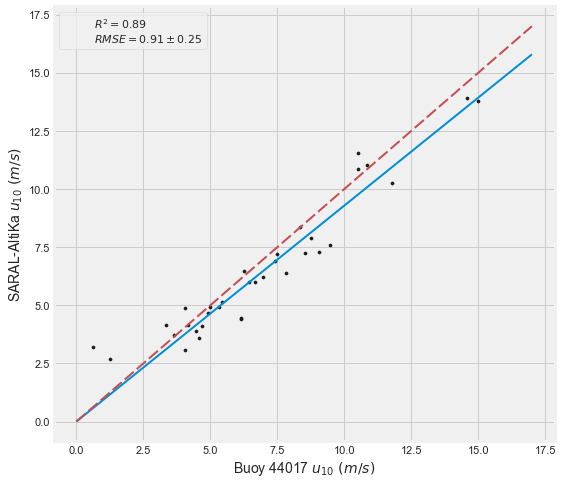

In [887]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(x, xx, s=10, color='k', label='data')
plt.plot(x1fit, y1fit, linewidth=2, label='fitted')
plt.plot([0, 17], [0, 17], dashes=[6, 2], linewidth=2, color='r', label='1-1 line')

plt.xlabel('Buoy 44017 $u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('SARAL-AltiKa $u_{10} \ (m/s)$', fontsize=14)

extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False, edgecolor='none', linewidth=0)
ax.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$').format(np.mean(scores['test_r2']),
                                                      -np.mean(scores['test_neg_root_mean_squared_error']),
                                                      np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')

In [888]:
model = LinearRegression(fit_intercept=False)

model.fit(y[:, np.newaxis], yy)

x2fit = np.linspace(0, 4, 1000)
y2fit = model.predict(x2fit[:, np.newaxis])

print("Model slope:", model.coef_)
#print("Model intercept:", model.intercept_)

Model slope: [0.99592345]


In [889]:
scores_mean = list()
scores_std = list()

scores = cross_validate(model, y[:, np.newaxis], yy, scoring=['r2', 'neg_root_mean_squared_error'], cv=6)

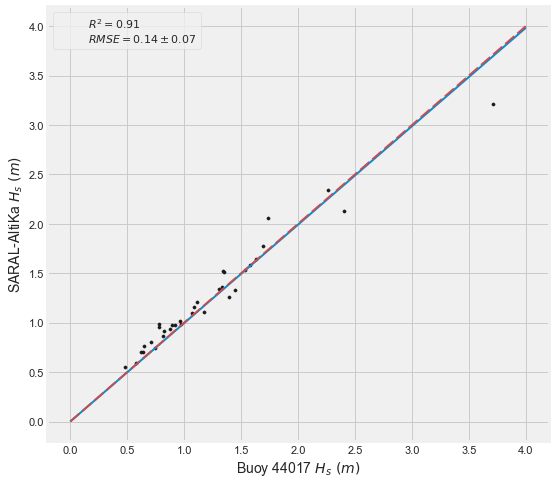

In [890]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(y, yy, s=10, color='k', label='data')
plt.plot(x2fit, y2fit, linewidth=2, label='fitted')
plt.plot([0, 4], [0, 4], dashes=[6, 2], linewidth=2, color='r', label='1-1 line')

plt.xlabel('Buoy 44017 $H_{s} \ (m)$', fontsize=14)
plt.ylabel('SARAL-AltiKa $H_{s} \ (m)$', fontsize=14)

extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
ax.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$').format(np.mean(scores['test_r2']),
                                                      -np.mean(scores['test_neg_root_mean_squared_error']),
                                                      np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')
#ax.legend(loc='best')

In [891]:
model = LinearRegression(fit_intercept=False)

model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 18, 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

In [877]:
# model / line coefficients
poly_model.steps[1][1].coef_

array([ 0.95046396, -0.08850961,  0.01510138])

In [878]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model, x[:, np.newaxis], y, scoring=['r2', 'neg_root_mean_squared_error'], cv=11)

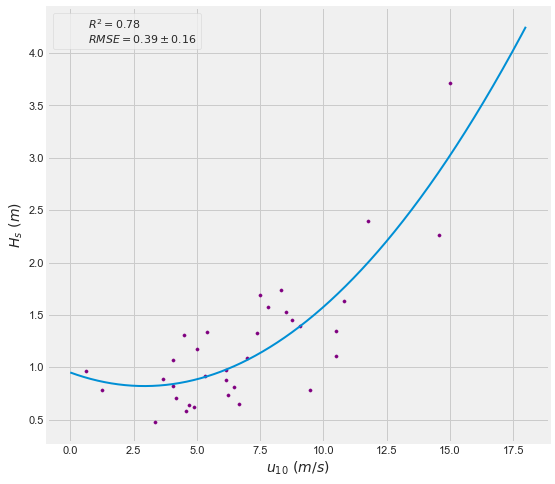

In [879]:
# plot time series of wave height and save figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df['Buoy 44017 U10'],df['Buoy 44017 Wave Height'],s=10,color='purple', label='Buoy 44017 data')

ax.plot(xfit, yfit, linewidth=2, label='Buoy 44017')

plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
#ax.legend(loc='best')
extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
ax.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_r2']),
                                                      -np.mean(scores['test_neg_root_mean_squared_error']),
                                                      np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')

In [880]:
model = LinearRegression(fit_intercept=False)

model.fit(xx[:, np.newaxis], yy)
xxfit = np.linspace(0, 18, 1000)

poly_model1 = make_pipeline(PolynomialFeatures(2), model)

poly_model1.fit(xx[:, np.newaxis], yy)
yyfit = poly_model1.predict(xxfit[:, np.newaxis])

In [881]:
poly_model1.steps[1][1].coef_

array([ 0.86132747, -0.02052031,  0.01037145])

In [882]:
scores_mean = list()
scores_std = list()

scores = cross_validate(poly_model1, xx[:, np.newaxis], yy, scoring=['r2', 'neg_root_mean_squared_error'], cv=11)

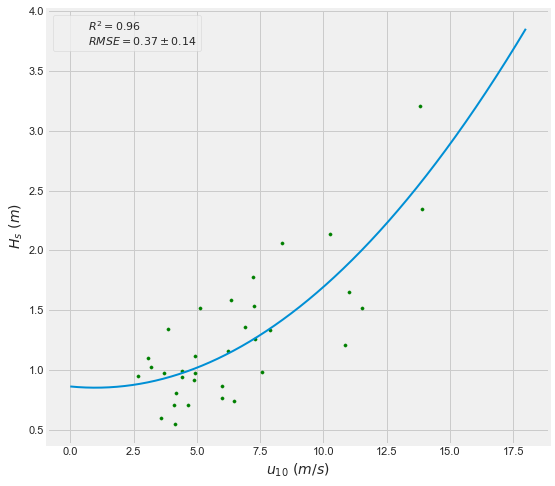

In [883]:
# plot time series of wave height and save figure
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(xx, yy, s=10, color='green', label='SARAL-AltiKa data')

ax.plot(xxfit, yyfit, linewidth=2, label="SARAL-AltiKa")
plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
#ax.legend(loc='best')
extra = plt.Rectangle((2, 2), 1, 1, facecolor="black", alpha=0, fill=False)
ax.legend([extra], [(r'$R^2={:.2f}$' + '\n' + r'$RMSE={:.2f} \pm {:.2f}$').format(-np.mean(scores['test_r2']),
                                                      -np.mean(scores['test_neg_root_mean_squared_error']),
                                                      np.std(scores['test_neg_root_mean_squared_error']))], loc='upper left')

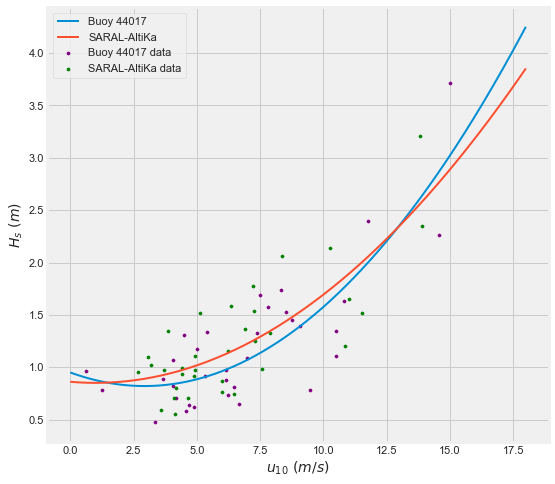

In [884]:
# plot time series of wave height and save figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df['Buoy 44017 U10'],df['Buoy 44017 Wave Height'],s=10,color='purple', label='Buoy 44017 data')
ax.scatter(xx, yy, s=10, color='green', label='SARAL-AltiKa data')
ax.plot(xfit, yfit, linewidth=2, label='Buoy 44017')
ax.plot(xxfit, yyfit, linewidth=2, label="SARAL-AltiKa")
plt.xlabel('$u_{10} \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)

#ax.set(xlabel="$u_{10} \ (m/s)$",
 #      ylabel="Significant Wave Height (m)")
ax.legend(loc='best')